Notebook for preprocessing of the bigram dataset to get valid noun noun compounds

In [1]:
import os
import glob
import csv
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.decomposition import PCA,TruncatedSVD
def lemmamaker_mod(word):
    return lemmatizer.lemmatize(word["modifier"],"n")

import pickle as pkl

def lemmamaker_head(word):

    return lemmatizer.lemmatize(word["head"],"n")
pd.options.mode.chained_assignment = None
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
bigrampath="bigrams_coha/"
bigram_files=glob.glob(os.path.join(bigrampath, "*.txt"))
def tf(x):
    return 1+np.log10(x)
import random
import re
#import nltk
#ps = nltk.PorterStemmer()
def patternmaker(x):
    x=np.array(x.notnull())
    x=x.astype(int)
    #print(x)
    val = ''.join(map(str, x))
    #print(val)
    return val



# Data extraction

The bigrams exist in several files in a directory and are loaded into one Dataframe.

The bigram dataset has the following fields -

**freq** - The frequency of the compound
**modifer** - Modifier in the compound 
**head** - Head in the compound
**modifier_tag** - The POS of the modifier
**head_tag** - The POS of the head
**decade** - The decade timestamp, where 1 is for 1810s, 2 for 1820s and so on.


In [18]:
bigram   = pd.concat((pd.read_csv(f,sep="\t",error_bad_lines=False,warn_bad_lines=False,header=None,quoting=csv.QUOTE_ALL,encoding='cp1252') for f in bigram_files),ignore_index =True)
bigram.columns=['freq','modifier','head','modifier_tag','head_tag','decade']
bigram.head(10)

,freq,modifier,head,modifier_tag,head_tag,decade
0,1,s,a,vbz,at1,6
1,1,s,a,vbz,at1,8
2,5,s,a,vbz,at1,16
3,4,s,a,vbz,at1,18
4,8,s,a,vbz,at1,20
5,1,s,all,vbz,db,6
6,1,s,all,vbz,db,16
7,3,s,all,vbz,db,18
8,1,s,all,vbz,db,20
9,1,s,and,vbz,cc,14


# Exploratory data analysis


Both the modifier and the head have different distribution as evidenced by the count of various tags.

nn1 and nn2 are the noun tags while jj is for adjectives.

In [19]:
modifier_pos_counts=bigram.modifier_tag.value_counts().to_frame()
modifier_pos_counts['perc']=round((modifier_pos_counts.modifier_tag/modifier_pos_counts.modifier_tag.sum())*100,3)
modifier_pos_counts.head()

,modifier_tag,perc
nn1,5751609,16.164
jj,5171905,14.534
nn2,2227089,6.259
rr,1717681,4.827
ii,1397426,3.927


In [20]:
head_pos_counts=bigram.head_tag.value_counts().to_frame()
head_pos_counts['perc']=round((head_pos_counts.head_tag/head_pos_counts.head_tag.sum())*100,3)
head_pos_counts.head()

,head_tag,perc
nn1,7289462,20.485
jj,3468896,9.749
nn2,3217905,9.043
ii,2710936,7.618
vvd,1452321,4.081


# Selection of only nouns

For the initial experimentation, only noun-noun compounds were considered. 
In particular, plural common nouns are **not** selected for the modifier as that violates the rules of compounding.

In [21]:
modifier_noun_tags=["nn","nn1","nn2"]
head_noun_tags=["nn","nn1","nn2"]
bigram=bigram[bigram.modifier_tag.isin(modifier_noun_tags) & bigram.head_tag.isin(head_noun_tags)]
#bigram=bigram[~bigram['decade'].isin([19,20])]
bigram.head(10)

,freq,modifier,head,modifier_tag,head_tag,decade
198,1,sa,famille,nn1,nn1,4
199,1,sa,famille,nn1,nn1,7
200,1,sa,famille,nn1,nn1,18
201,1,sa,id,nn1,nn1,11
202,1,sa,id,nn1,nn1,15
203,1,sa,id,nn1,nn1,19
204,1,sa,id,nn1,nn1,20
205,16,sa,nashtio,nn1,nn1,9
206,1,sa,propre,nn1,nn1,5
207,1,sa,propre,nn1,nn1,9


Unlike the unigram dataset, the bigram dataset includes the 2 more decades - 1990's and 2000's and hence compounds that exist in these 2 decades would be considered **novel compounds**.

In [22]:
decade_counts=bigram.decade.value_counts().to_frame()
decade_counts['perc']=round((decade_counts.decade/decade_counts.decade.sum())*100,3)
decade_counts

,decade,perc
20,93013,9.825
19,92306,9.751
18,82093,8.672
17,77123,8.147
16,76494,8.080
15,75284,7.952
14,71267,7.528
13,66633,7.039
12,59658,6.302
11,44264,4.676


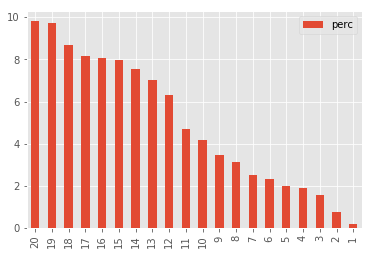

In [23]:
decade_counts.drop('decade',axis=1).plot.bar()

In [24]:
#modifier_tags=["nn","nn1","jj"]
#modifier_noun_tags=["nn","nn1"]
#modifier_adj_tags=["jj"]
#noun_tags=["nd1","nn","nn1","nn2","nna","nnb","nnl1","nnl2","nno","nno2","nnt1","nnt2","np","np1","np2"]

#adj=dict.fromkeys(modifier_adj_tags,'adj')
modifier_noun_counts=modifier_pos_counts[modifier_pos_counts.index.isin(modifier_noun_tags)]
print(modifier_noun_counts)
print("\n Percentage of modifiers that are nouns is", round(modifier_noun_counts.perc.sum(),3) ,"%")

     modifier_tag   perc
nn1       5751609 16.164
nn2       2227089  6.259
nn          78984  0.222

 Percentage of modifiers that are nouns is 22.645 %


In [25]:
head_noun_tags=["nn","nn1","nn2"]
nouns=dict.fromkeys(head_noun_tags,'noun')
head_noun_counts=head_pos_counts[head_pos_counts.index.isin(head_noun_tags)]
print(head_noun_counts)
print("\n Percentage of heads that are nouns is", round(head_noun_counts.perc.sum(),3) ,"%")

     head_tag   perc
nn1   7289462 20.485
nn2   3217905  9.043
nn      95963  0.270

 Percentage of heads that are nouns is 29.798 %


In [26]:
bigram.drop(["modifier_tag","head_tag"],axis=1,inplace=True)

# Lemmatization


Lemmatization is performed for both modifier and head columns.

Following operations were performed -

1. substitute all noun tags with 'noun'
2. merge the head and its tag together
3. merge the modifier and its tag together
4. reduce all words to lowercase

In [27]:

bigram['modifier']=bigram['modifier'].str.lower()
bigram['head']=bigram['head'].str.lower()

bigram['head']=bigram['head'].apply(lambda x: lemmatizer.lemmatize(x))
bigram['modifier']=bigram['modifier'].apply(lambda x: lemmatizer.lemmatize(x))

bigram.head(10)

,freq,modifier,head,decade
198,1,sa,famille,4
199,1,sa,famille,7
200,1,sa,famille,18
201,1,sa,id,11
202,1,sa,id,15
203,1,sa,id,19
204,1,sa,id,20
205,16,sa,nashtio,9
206,1,sa,propre,5
207,1,sa,propre,9


In [28]:
bigram.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 946676 entries, 198 to 35582621
Data columns (total 4 columns):
freq        946676 non-null int64
modifier    946676 non-null object
head        946676 non-null object
decade      946676 non-null int64
dtypes: int64(2), object(2)
memory usage: 36.1+ MB


Some rows need to be merged after the tag class being simplified.
Also only compounds occuring at least 3 times in a decade are chosen.

In [29]:
bigram=bigram.groupby(['modifier','head','decade'])['freq'].sum().to_frame()
bigram=bigram[bigram.freq>=3]
bigram.head(10)

freq
modifier head     decade      
a        dey      8          4
         ef       8          5
         fur      8          4
         tho      6          7
         youer    8          7
a--a     monsieur 10         3
a-class  leady    15        12
a-frame  cottage  18         3
a-gonna  git      14         3
a-level  exam     20         5

In [31]:
bigram.reset_index(inplace=True)

In [43]:
head_list=bigram["head"].unique().tolist()
pkl.dump( head_list, open( "head_list.p", "wb" ) )

In [44]:
modifier_list=bigram["modifier"].unique().tolist()
pkl.dump( modifier_list, open( "modifier_list.p", "wb" ) )

In [14]:
modifiers=pd.pivot_table(bigram,index=['modifier','decade'],columns='head',values='freq',aggfunc=np.sum)
heads=pd.pivot_table(bigram,index=['head','decade'],columns='modifier',values='freq',aggfunc=np.sum)

In [15]:
modifiers.index.rename(['word','decade'],inplace=True)
heads.index.rename(['word','decade'],inplace=True)

In [16]:
modifiers.columns=modifiers.columns+'_head'
heads.columns=heads.columns+'_modifier'

In [17]:
words=pd.merge(modifiers.reset_index(),heads.reset_index(),on=['word','decade'],how='outer',sort=False)
words.set_index(['word','decade'],inplace=True)
words

a_head  a'throat_head  a--a_head  a-kimbo_head  \
word        decade                                                   
a           6          nan            nan        nan           nan   
            8          nan            nan        nan           nan   
a--a        10         nan            nan        nan           nan   
a-class     15         nan            nan        nan           nan   
a-frame     18         nan            nan        nan           nan   
a-gonna     14         nan            nan        nan           nan   
a-v         15         nan            nan        nan           nan   
aba         17         nan            nan        nan           nan   
abalone     9          nan            nan        nan           nan   
            12         nan            nan        nan           nan   
            14         nan            nan        nan           nan   
abbey       4          nan            nan        nan           nan   
            7          nan            nan        nan           nan   
            8          nan            nan        nan           nan   
            9          nan            nan        nan           nan   
            10         nan            nan        nan           nan   
            11         nan            nan        nan           nan   
            12         nan            nan        nan           nan   
            13         nan            nan        nan           nan   
            16         nan            nan        nan           nan   
            18         nan            nan        nan           nan   
abc         18         nan            nan        nan           nan   
abeyance    6          nan            nan        nan           nan   
abimelech   4          nan            nan        nan           nan   
ablishnists 6          nan            nan        nan           nan   
abner       6          nan            nan        nan           nan   
abolition   2          nan            nan        nan           nan   
            3          nan            nan        nan           nan   
            4          nan            nan        nan           nan   
            5          nan            nan        nan           nan   
...                    ...            ...        ...           ...   
zeal        5          nan            nan        nan           nan   
            6          nan            nan        nan           nan   
            7          nan            nan        nan           nan   
            8          nan            nan        nan           nan   
            9          nan            nan        nan           nan   
            10         nan            nan        nan           nan   
            11         nan            nan        nan           nan   
            14         nan            nan        nan           nan   
            15         nan            nan        nan           nan   
            18         nan            nan        nan           nan   
zee         6          nan            nan        nan           nan   
zegri       2          nan            nan        nan           nan   
zeil        2          nan            nan        nan           nan   
zeisberger  17         nan            nan        nan           nan   
zero        15         nan            nan        nan           nan   
zeta        13         nan            nan        nan           nan   
zi          18         nan            nan        nan           nan   
ziani       3          nan            nan        nan           nan   
ziel        2          nan            nan        nan           nan   
zionist     16         nan            nan        nan           nan   
zodiac      12         nan            nan        nan           nan   
zon         2          nan            nan        nan           nan   
zone        12         nan            nan        nan           nan   
zoo         12         nan            nan        nan           nan   
zoon        8          nan    

In [18]:
tot_count=np.nansum(words.values)

In [19]:
words=words.applymap(lambda x: x/tot_count)
words["sum"]=words.sum(axis=1)
words.head(10)

a_head  a'throat_head  a--a_head  a-kimbo_head  a-settin_head  \
word    decade                                                                  
a       6          nan            nan        nan           nan            nan   
        8          nan            nan        nan           nan            nan   
a--a    10         nan            nan        nan           nan            nan   
a-class 15         nan            nan        nan           nan            nan   
a-frame 18         nan            nan        nan           nan            nan   
a-gonna 14         nan            nan        nan           nan            nan   
a-v     15         nan            nan        nan           nan            nan   
aba     17         nan            nan        nan           nan            nan   
abalone 9          nan            nan        nan           nan            nan   
        12         nan            nan        nan           nan            nan   

                a-wushin_head  ab_head  abamoko_head  abandonment_head  \
word    decade                                                           
a       6                 nan      nan           nan               nan   
        8                 nan      nan           nan               nan   
a--a    10                nan      nan           nan               nan   
a-class 15                nan      nan           nan               nan   
a-frame 18                nan      nan           nan               nan   
a-gonna 14                nan      nan           nan               nan   
a-v     15                nan      nan           nan               nan   
aba     17                nan      nan           nan               nan   
abalone 9                 nan      nan           nan               nan   
        12                nan      nan           nan               nan   

                abatement_head  ...   zoo_modifier  zoology_modifier  \
word    decade                  ...                                    
a       6                  nan  ...            nan               nan   
        8                  nan  ...            nan               nan   
a--a    10                 nan  ...            nan               nan   
a-class 15                 nan  ...            nan               nan   
a-frame 18                 nan  ...            nan               nan   
a-gonna 14                 nan  ...            nan               nan   
a-v     15                 nan  ...            nan               nan   
aba     17                 nan  ...            nan               nan   
abalone 9                  nan  ...            nan               nan   
        12                 nan  ...            nan               nan   

                zoom_modifier  zoot_modifier  zu_modifier  zucchini_modifier  \
word    decade                                                                 
a       6                 nan            nan          nan                nan   
        8                 nan            nan          nan                nan   
a--a    10                nan            nan          nan                nan   
a-class 15                nan            nan          nan                nan   
a-frame 18                nan            nan          nan                nan   
a-gonna 14                nan            nan          nan                nan   
a-v     15                nan            nan          nan                nan   
aba     17                nan            nan          nan                nan   
abalone 9                 nan            nan          nan                nan   
        12                nan            nan          nan                nan   

                zuider_modifier  zum_modifier  zust_modifier   sum  
word    decade                                                      
a       6                   nan           nan            nan 0.000  
        8                   nan           nan            nan 0.000  
a--a    10                  nan           nan       

In [20]:
words[words.columns[:-1]]=words[words.columns[:-1]]/(words[words.columns[:-1]].sum(axis=0)**0.75)
words.head(10)

a_head  a'throat_head  a--a_head  a-kimbo_head  a-settin_head  \
word    decade                                                                  
a       6          nan            nan        nan           nan            nan   
        8          nan            nan        nan           nan            nan   
a--a    10         nan            nan        nan           nan            nan   
a-class 15         nan            nan        nan           nan            nan   
a-frame 18         nan            nan        nan           nan            nan   
a-gonna 14         nan            nan        nan           nan            nan   
a-v     15         nan            nan        nan           nan            nan   
aba     17         nan            nan        nan           nan            nan   
abalone 9          nan            nan        nan           nan            nan   
        12         nan            nan        nan           nan            nan   

                a-wushin_head  ab_head  abamoko_head  abandonment_head  \
word    decade                                                           
a       6                 nan      nan           nan               nan   
        8                 nan      nan           nan               nan   
a--a    10                nan      nan           nan               nan   
a-class 15                nan      nan           nan               nan   
a-frame 18                nan      nan           nan               nan   
a-gonna 14                nan      nan           nan               nan   
a-v     15                nan      nan           nan               nan   
aba     17                nan      nan           nan               nan   
abalone 9                 nan      nan           nan               nan   
        12                nan      nan           nan               nan   

                abatement_head  ...   zoo_modifier  zoology_modifier  \
word    decade                  ...                                    
a       6                  nan  ...            nan               nan   
        8                  nan  ...            nan               nan   
a--a    10                 nan  ...            nan               nan   
a-class 15                 nan  ...            nan               nan   
a-frame 18                 nan  ...            nan               nan   
a-gonna 14                 nan  ...            nan               nan   
a-v     15                 nan  ...            nan               nan   
aba     17                 nan  ...            nan               nan   
abalone 9                  nan  ...            nan               nan   
        12                 nan  ...            nan               nan   

                zoom_modifier  zoot_modifier  zu_modifier  zucchini_modifier  \
word    decade                                                                 
a       6                 nan            nan          nan                nan   
        8                 nan            nan          nan                nan   
a--a    10                nan            nan          nan                nan   
a-class 15                nan            nan          nan                nan   
a-frame 18                nan            nan          nan                nan   
a-gonna 14                nan            nan          nan                nan   
a-v     15                nan            nan          nan                nan   
aba     17                nan            nan          nan                nan   
abalone 9                 nan            nan          nan                nan   
        12                nan            nan          nan                nan   

                zuider_modifier  zum_modifier  zust_modifier   sum  
word    decade                                                      
a       6                   nan           nan            nan 0.000  
        8                   nan           nan            nan 0.000  
a--a    10                  nan           nan       

In [21]:
#words[words.columns[:-1]]=
words=words.drop('sum',axis=1).div(words["sum"], axis=0)
words.head(10)

KeyboardInterrupt: 

In [24]:
words=words.applymap(lambda x:np.log2(x))
words.head(10)

a_head  a'throat_head  a--a_head  a-kimbo_head  a-settin_head  \
word    decade                                                                  
a       6          nan            nan        nan           nan            nan   
        8          nan            nan        nan           nan            nan   
a--a    10         nan            nan        nan           nan            nan   
a-class 15         nan            nan        nan           nan            nan   
a-frame 18         nan            nan        nan           nan            nan   
a-gonna 14         nan            nan        nan           nan            nan   
a-v     15         nan            nan        nan           nan            nan   
aba     17         nan            nan        nan           nan            nan   
abalone 9          nan            nan        nan           nan            nan   
        12         nan            nan        nan           nan            nan   

                a-wushin_head  ab_head  abamoko_head  abandonment_head  \
word    decade                                                           
a       6                 nan      nan           nan               nan   
        8                 nan      nan           nan               nan   
a--a    10                nan      nan           nan               nan   
a-class 15                nan      nan           nan               nan   
a-frame 18                nan      nan           nan               nan   
a-gonna 14                nan      nan           nan               nan   
a-v     15                nan      nan           nan               nan   
aba     17                nan      nan           nan               nan   
abalone 9                 nan      nan           nan               nan   
        12                nan      nan           nan               nan   

                abatement_head      ...        zoning_modifier  zoo_modifier  \
word    decade                      ...                                        
a       6                  nan      ...                    nan           nan   
        8                  nan      ...                    nan           nan   
a--a    10                 nan      ...                    nan           nan   
a-class 15                 nan      ...                    nan           nan   
a-frame 18                 nan      ...                    nan           nan   
a-gonna 14                 nan      ...                    nan           nan   
a-v     15                 nan      ...                    nan           nan   
aba     17                 nan      ...                    nan           nan   
abalone 9                  nan      ...                    nan           nan   
        12                 nan      ...                    nan           nan   

                zoology_modifier  zoom_modifier  zoot_modifier  zu_modifier  \
word    decade                                                                
a       6                    nan            nan            nan          nan   
        8                    nan            nan            nan          nan   
a--a    10                   nan            nan            nan          nan   
a-class 15                   nan            nan            nan          nan   
a-frame 18                   nan            nan            nan          nan   
a-gonna 14                   nan            nan            nan          nan   
a-v     15                   nan            nan            nan          nan   
aba     17                   nan            nan            nan          nan   
abalone 9                    nan            nan            nan          nan   
        12                   nan            nan            nan          nan   

                zucchini_modifier  zuider_modifier  zum_modifier  \
word    decade                                                     
a       6                     nan              nan           nan   
        8                     nan       

In [25]:
words=words.fillna(0)
words[words<0]=0
words

a_head  a'throat_head  a--a_head  a-kimbo_head  \
word        decade                                                   
a           6        0.000          0.000      0.000         0.000   
            8        0.000          0.000      0.000         0.000   
a--a        10       0.000          0.000      0.000         0.000   
a-class     15       0.000          0.000      0.000         0.000   
a-frame     18       0.000          0.000      0.000         0.000   
a-gonna     14       0.000          0.000      0.000         0.000   
a-v         15       0.000          0.000      0.000         0.000   
aba         17       0.000          0.000      0.000         0.000   
abalone     9        0.000          0.000      0.000         0.000   
            12       0.000          0.000      0.000         0.000   
            14       0.000          0.000      0.000         0.000   
abbey       4        0.000          0.000      0.000         0.000   
            7        0.000          0.000      0.000         0.000   
            8        0.000          0.000      0.000         0.000   
            9        0.000          0.000      0.000         0.000   
            10       0.000          0.000      0.000         0.000   
            11       0.000          0.000      0.000         0.000   
            12       0.000          0.000      0.000         0.000   
            13       0.000          0.000      0.000         0.000   
            16       0.000          0.000      0.000         0.000   
            18       0.000          0.000      0.000         0.000   
abc         18       0.000          0.000      0.000         0.000   
abeyance    6        0.000          0.000      0.000         0.000   
abimelech   4        0.000          0.000      0.000         0.000   
ablishnists 6        0.000          0.000      0.000         0.000   
abner       6        0.000          0.000      0.000         0.000   
abolition   2        0.000          0.000      0.000         0.000   
            3        0.000          0.000      0.000         0.000   
            4        0.000          0.000      0.000         0.000   
            5        0.000          0.000      0.000         0.000   
...                    ...            ...        ...           ...   
zeal        5        0.000          0.000      0.000         0.000   
            6        0.000          0.000      0.000         0.000   
            7        0.000          0.000      0.000         0.000   
            8        0.000          0.000      0.000         0.000   
            9        0.000          0.000      0.000         0.000   
            10       0.000          0.000      0.000         0.000   
            11       0.000          0.000      0.000         0.000   
            14       0.000          0.000      0.000         0.000   
            15       0.000          0.000      0.000         0.000   
            18       0.000          0.000      0.000         0.000   
zee         6        0.000          0.000      0.000         0.000   
zegri       2        0.000          0.000      0.000         0.000   
zeil        2        0.000          0.000      0.000         0.000   
zeisberger  17       0.000          0.000      0.000         0.000   
zero        15       0.000          0.000      0.000         0.000   
zeta        13       0.000          0.000      0.000         0.000   
zi          18       0.000          0.000      0.000         0.000   
ziani       3        0.000          0.000      0.000         0.000   
ziel        2        0.000          0.000      0.000         0.000   
zionist     16       0.000          0.000      0.000         0.000   
zodiac      12       0.000          0.000      0.000         0.000   
zon         2        0.000          0.000      0.000         0.000   
zone        12       0.000          0.000      0.000         0.000   
zoo         12       0.000          0.000      0.000         0.000   
zoon        8        0.000    

In [28]:
words.sum(axis=1).describe()

count   74694.000
mean       27.213
std        32.812
min         5.208
25%         9.350
50%        14.509
75%        29.720
max       444.374
dtype: float64

In [31]:
np.std(words.values)

0.092167280488528888

In [53]:
pca = PCA(svd_solver='arpack', n_components='mle')
pca.fit(words)


print(pca.explained_variance_ratio_)  

ValueError: n_components='mle' cannot be a string with svd_solver='arpack'

In [51]:
np.sum(pca.explained_variance_ratio_)

0.088513833246305254

# Shallow to dense representation

We can now finally pivot the dataset (convert it from a shallow to dense represenation).

I have also added 3 extra columns which are,

**cf** : Collection frequency, which is the log of the sum of the term across decades, ie log(1+sum(term).

**presence** : Number of decades a term is present in.

**pattern** : A string that is of length 18. A 0 if the word was not present in the particular decade and 1 otherwise. Could be useful later on during the LSTM reprsentation.

Also, the decades are now suitably labeled.

In order to reduce bias against words with extremely high frequencies, all counts are logarithmically reduced.


In [ ]:
bigram=pd.pivot_table(bigram,index=['modifier','head'],columns='decade',values='freq',aggfunc=np.sum)
#bigram=bigram[bigram.freq>=5]
bigram.columns=['1810s','1820s','1830s','1840s','1850s','1860s','1870s','1880s','1890s','1900s','1910s','1920s','1930s','1940s','1950s','1960s','1970s','1980s','1990s','2000s']
precolumns=bigram.columns[:-2]
postcolumns=bigram.columns[-2:]
#new_decades=bigram[['1990s','2000s']]
#bigram.drop(['1990s','2000s'],axis=1,inplace=True)
#bigram=bigram[((bigram['1990s'].notnull()==True)  & (bigram['2000s'].notnull()==True))]
bigram['cf']=bigram[precolumns].sum(axis=1)
bigram['presence']=bigram[precolumns].count(axis=1)
bigram['presence']=bigram["presence"].astype('category')
#bigram[bigram.columns[:-2]]=bigram[bigram.columns[:-2]].applymap(tf)
bigram['pattern']=bigram[precolumns].apply(patternmaker,axis=1)
bigram['pattern']=bigram["pattern"].astype('category')
#bigram.cf.replace(-np.inf,0,inplace=True)
bigram

In [ ]:
bigram.describe()

In [ ]:
novel_compounds=bigram[bigram.presence==0 & (bigram[postcolumns].isnull().any(axis=1))].index.tolist()
#bigram[postcolumns].isnull().any(axis=1)
print("There are",len(novel_compounds),"novel compounds in the deacdes 1990s and 2000s.")

In [ ]:
bigram.to_csv('bigrams.csv',sep="\t")

# End of Report

All the details below are not important for the Novel Compound Generation and were for data analysis.

In [ ]:
pattern_counts=bigram.pattern.value_counts().to_frame()
pattern_counts['perc']=round((pattern_counts['pattern']/pattern_counts['pattern'].sum())*100,3)
pattern_counts.sort_index(inplace=True)
pattern_counts

In [ ]:
pattern_counts[pattern_counts.pattern>=1000].sort_values('perc', ascending=False).head(20).drop('pattern',axis=1).plot.bar(figsize=(10,10))

In [ ]:
decade_presence=bigram.presence.value_counts().to_frame()
decade_presence['perc']=round((decade_presence.presence/decade_presence.presence.sum())*100,3)
decade_presence.sort_index(inplace=True)
decade_presence

In [ ]:
fig, ax = plt.subplots()
decade_presence.drop('presence',axis=1).plot.bar(ax=ax,figsize=(10,10))
plt.xlabel('Number of decades the bigram is present in', fontsize=18)
plt.ylabel('Proportion of words', fontsize=18)
plt.show()

In [ ]:
fig, ax = plt.subplots()
bigram.drop('presence',axis=1).plot.box(ax=ax,showfliers=True,figsize=(20,15),legend =True,notch=True)

plt.xlabel('Decades', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

In [ ]:
bigram.hist(figsize=(20,20),alpha=0.5,bins=20,normed=1,sharex=True,sharey=True)

In [ ]:
bigram.xs('news_noun',level='head')